# Kenya vs West
In this notebook i performed statistics included in the scikit-allel package between Kenya and Far-West pops (Gambia and Guinea-Bissau)
Workflow:
 - Taking out 3R-free region from Positions, Variants, Genotype and Allele Count
 - Locate and take variants with (QD > 5) & (MQ > 40) & (DP > 15000) & (DP < 30000)
 - Subset Ag1000G calldata to pops: KE, GM and GW

Apply the statistics:

    - Site frequency spectra
    - Tajima's D
    - Delta Tajima's D
    - Pi
    - Average Dxy
    - Watterson's Theta
    - Observed Heterozigosity vs Expected Heterozigosity
    - Inbreeding Coefficent

### Importing modules and Ag1000G phase 2 calldata

In [1]:
%run imports.ipynb
%run '08222019_functions.ipynb'

In [2]:
calldata_biallel= zarr.open('data/phase2_biallel_allele_count.zarr/')

Taking out the 3R-free region:

In [3]:
pos_all = allel.SortedIndex(callset_biallel['3R']["variants/POS"])
loc = pos_all.intersect_range(1000000, 37000000)
loc1, loc2 = pos_all.locate_intersection(loc)

In [4]:
pos_3R_free = pos_all.compress(loc1)
pos_3R_free

0,1,2,3,4,...,8281761,8281762,8281763,8281764,8281765
1000000,1000005,1000007,1000012,1000013,...,36999969,36999970,36999971,36999973,36999976


----------
Loading variants and taking only the variants that have passed the filter:

In [5]:
variants = allel.VariantChunkedTable(callset_biallel['3R']['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD'],
                                     index='POS')
variants_3R_free = variants.compress(loc1)

In [6]:
filter_expression = '(QD > 5) & (MQ > 40) & (DP > 15000) & (DP < 30000)'

In [7]:
variant_selection = variants_3R_free.eval(filter_expression)[:]
variant_selection

array([False, False, False, ..., False, False, False])

In [8]:
variants_pass = variants_3R_free.compress(variant_selection)
variants_pass

<VariantChunkedTable shape=(318962,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1'), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=5.5M cbytes=3.3M cratio=1.7
   values=allel.chunked.storage_zarr.ZarrTable>

-------------
Loading the genotype and subset it to the 3R-free region

In [9]:
genotypes = allel.GenotypeChunkedArray(callset_biallel['3R']["calldata/GT"])
genotypes

<GenotypeChunkedArray shape=(10752701, 1142, 2) dtype=int8 chunks=(524288, 61, 2)
   nbytes=22.9G cbytes=-1 cratio=-24559169084.0
   compression=blosc compression_opts={'cname': 'zstd', 'clevel': 1, 'shuffle': -1, 'blocksize': 0}
   values=zarr.core.Array>

In [10]:
genotypes_3R_free = genotypes.compress(loc1)
genotypes_3R_free

<GenotypeChunkedArray shape=(8281766, 1142, 2) dtype=int8 chunks=(2022, 1142, 2)
   nbytes=17.6G cbytes=752.1M cratio=24.0
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

--------------
Subset the metadata to my 3 pops of interest

In [11]:
sample_selection = metadata.population.isin({'KE', 'GM', 'GW'}).values

In [12]:
samples_subset = metadata[sample_selection]
samples_subset.reset_index(drop=True, inplace=True)
samples_subset.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AG0082-C,2518,GM,"Gambia, The",Njabakunda,Sare Illo Buya,Martin Donnelly,Martin Donnelly,2011,NaN,F,93088052,30.53,ERS248676,13.55,-15.9
1,AG0085-C,2521,GM,"Gambia, The",Njabakunda,Sare Illo Buya,Martin Donnelly,Martin Donnelly,2011,NaN,F,103517758,32.14,ERS248679,13.55,-15.9
2,AG0089-C,2525,GM,"Gambia, The",Njabakunda,Sare Illo Buya,Martin Donnelly,Martin Donnelly,2011,NaN,F,114898838,35.13,ERS248683,13.55,-15.9
3,AG0096-C,2532,GM,"Gambia, The",Njabakunda,Sare Illo Buya,Martin Donnelly,Martin Donnelly,2011,NaN,F,105627176,32.73,ERS248690,13.55,-15.9
4,AG0097-C,2533,GM,"Gambia, The",Njabakunda,Sare Illo Buya,Martin Donnelly,Martin Donnelly,2011,NaN,F,95764982,23.23,ERS248691,13.55,-15.9


In [13]:
samples_subset.population.value_counts()

GW    91
GM    65
KE    48
Name: population, dtype: int64

----------
Subset the genotype to variants passed and pops

In [14]:
%%time
genotypes_subset = genotypes.subset(variant_selection, sample_selection)

CPU times: user 1min 12s, sys: 19.4 s, total: 1min 32s
Wall time: 1min 3s


-----------
Counting the alleles:

In [15]:
subpops = {
    'all': list(range(len(samples_subset))),
    'GM': samples_subset[samples_subset.population == 'GM'].index.tolist(),
    'GW': samples_subset[samples_subset.population == 'GW'].index.tolist(),
    'KE': samples_subset[samples_subset.population == 'KE'].index.tolist(),

}

In [16]:
%%time
ac_subpops = genotypes_subset.count_alleles_subpops(subpops, max_allele=3)
ac_subpops

CPU times: user 1.27 s, sys: 30 ms, total: 1.3 s
Wall time: 1.25 s


<AlleleCountsChunkedTable shape=(318962,) dtype=[('GM', '<i4', (4,)), ('GW', '<i4', (4,)), ('KE', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=19.5M cbytes=1.5M cratio=12.8
   values=allel.chunked.storage_zarr.ZarrTable>

--------
Locate segregating variants and subset to my allel count and to the 3R-free positions:

In [17]:
is_seg = ac_subpops['all'].is_segregating()[:]
is_seg

array([ True,  True,  True, ...,  True, False,  True])

In [18]:
genotypes_seg = genotypes_subset.compress(is_seg, axis=0)
genotypes_seg

<GenotypeChunkedArray shape=(116102, 204, 2) dtype=int8 chunks=(1815, 204, 2)
   nbytes=45.2M cbytes=4.5M cratio=10.0
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [19]:
variants_seg = variants_pass.compress(is_seg)
variants_seg

<VariantChunkedTable shape=(116102,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1'), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=2.0M cbytes=1.2M cratio=1.6
   values=allel.chunked.storage_zarr.ZarrTable>

In [20]:
ac_seg = ac_subpops.compress(is_seg)
ac_seg

<AlleleCountsChunkedTable shape=(116102,) dtype=[('GM', '<i4', (4,)), ('GW', '<i4', (4,)), ('KE', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=7.1M cbytes=851.4K cratio=8.5
   values=allel.chunked.storage_zarr.ZarrTable>

In [21]:
loc1, loc2 = pos_3R_free.locate_intersection(variants_seg['POS'][:])

In [22]:
pos_3R_free_seg = pos_3R_free.compress(loc1)
pos_3R_free_seg

0,1,2,3,4,...,116097,116098,116099,116100,116101
1000273,1000276,1000279,1000283,1005228,...,36993953,36993954,36993986,36993987,36999147


----------------
Site frequency spectra

In [23]:
is_biallelic_01 = ac_seg['all'].is_biallelic_01()[:]
ac1 = ac_seg['GM'].compress(is_biallelic_01, axis=0)[:, :2]
ac2 = ac_seg['GW'].compress(is_biallelic_01, axis=0)[:, :2]
ac3 = ac_seg['KE'].compress(is_biallelic_01, axis=0)[:, :2]

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


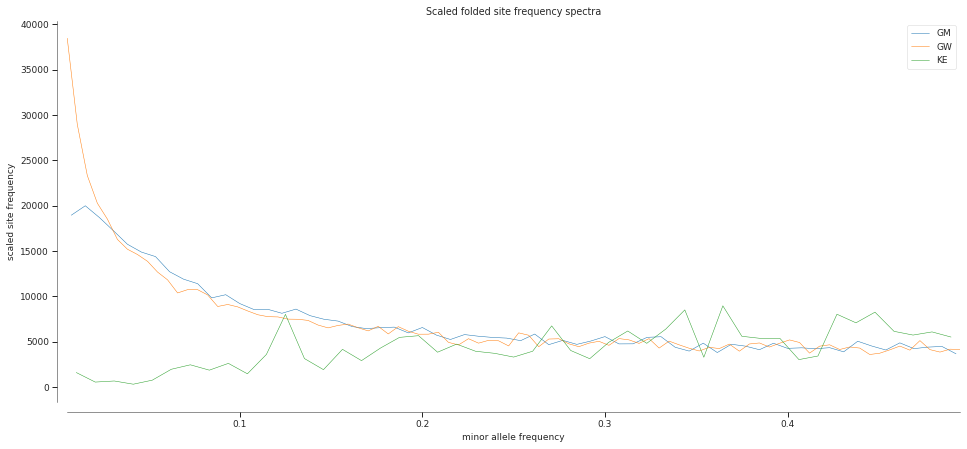

In [24]:
fig, ax = plt.subplots(figsize=(16, 7))
sns.despine(ax=ax, offset=10)
sfs1 = allel.sfs_folded_scaled(ac1)
allel.plot_sfs_folded_scaled(sfs1, ax=ax, label='GM', n=ac1.sum(axis=1).max())
sfs2 = allel.sfs_folded_scaled(ac2)
allel.plot_sfs_folded_scaled(sfs2, ax=ax, label='GW', n=ac2.sum(axis=1).max())
sfs3 = allel.sfs_folded_scaled(ac3)
allel.plot_sfs_folded_scaled(sfs3, ax=ax, label='KE', n=ac3.sum(axis=1).max())
ax.legend()
ax.set_title('Scaled folded site frequency spectra')
# workaround bug in scikit-allel re axis naming
ax.set_xlabel('minor allele frequency');

----------
Tajima's D

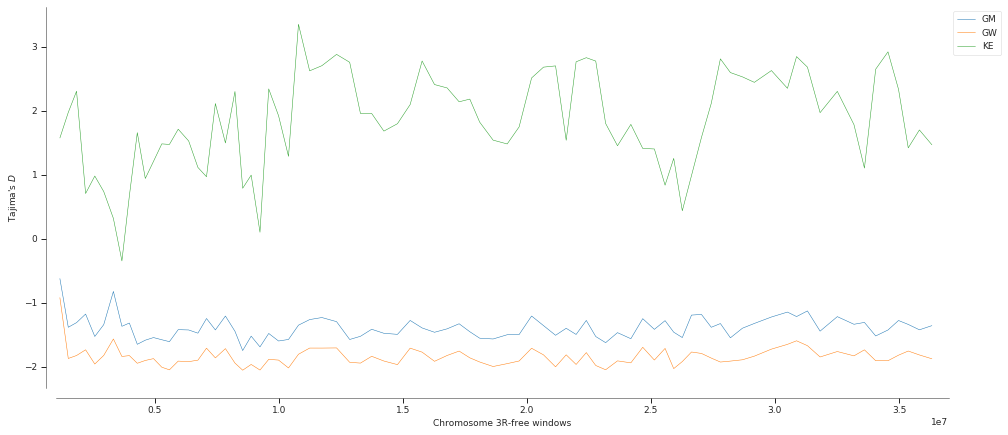

In [25]:
# compute windows with equal numbers of SNPs
windows = allel.moving_statistic(pos_3R_free, statistic=lambda v: [v[0], v[-1]], size=100000)
x = np.asarray(windows).mean(axis=1)

# compute Tajima's D
y1, _, _ = allel.windowed_tajima_d(pos_3R_free_seg, ac_seg['GM'][:], windows=windows)
y2, _, _ = allel.windowed_tajima_d(pos_3R_free_seg, ac_seg['GW'][:], windows=windows)
y3, _, _ = allel.windowed_tajima_d(pos_3R_free_seg, ac_seg['KE'][:], windows=windows)

# plot
fig, ax = plt.subplots(figsize=(16, 7))
sns.despine(ax=ax, offset=10)
ax.plot(x, y1, lw=.5, label='GM')
ax.plot(x, y2, lw=.5, label='GW')
ax.plot(x, y3, lw=.5, label='KE')

ax.set_ylabel("Tajima's $D$")
ax.set_xlabel('Chromosome 3R-free windows')
ax.set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));

-----------
pi

In [26]:
is_accessible = accessibility['3R']['is_accessible'][:]

In [40]:
pi_gm, windows_gm, n_bases_gm, counts_gm = allel.windowed_diversity(pos_3R_free_seg, ac_seg['GM'], size=1000000, start=pos_all.min(), stop=pos_all.max(), is_accessible=is_accessible)
pi_gw, windows_gw, n_bases_gw, counts_gw = allel.windowed_diversity(pos_3R_free_seg, ac_seg['GW'], size=1000000, start=pos_all.min(), stop=pos_all.max(), is_accessible=is_accessible)
pi_ke, windows_ke, n_bases_ke, counts_ke = allel.windowed_diversity(pos_3R_free_seg, ac_seg['KE'], size=1000000, start=pos_all.min(), stop=pos_all.max(), is_accessible=is_accessible)

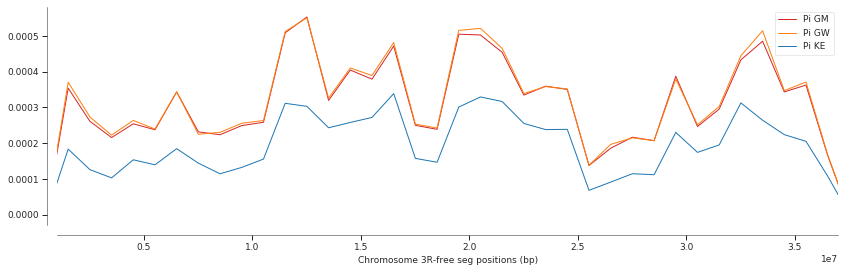

In [61]:
fig, ax = plt.subplots(figsize=(14, 4))
min_n_bases=1
x1 = np.mean(windows_gm[n_bases_gm >= min_n_bases], axis=1)
y1 = pi_gm[n_bases_gm >= min_n_bases]
plt.plot(x1, y1, lw=1, label = "Pi GM", color=palette[3]) 


x2 = np.mean(windows_gw[n_bases_gw >= min_n_bases], axis=1)
y2 = pi_gw[n_bases_gm >= min_n_bases]
plt.plot(x2, y2, lw=1, label = "Pi GW", color=palette[1]) 

x3 = np.mean(windows_ke[n_bases_ke >= min_n_bases], axis=1)
y3 = pi_ke[n_bases_gm >= min_n_bases]
plt.plot(x3, y3, lw=1, label = "Pi KE", color=palette[0]) 

ax.set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())
ax.set_xlabel('Chromosome 3R-free seg positions (bp)')
sns.despine(ax=ax, offset=10)
# show a legend on the plot 
plt.legend() 

# function to show the plot 
plt.show()

--------------------------------------------------

Delta tajima's d

In [99]:
t1 = allel.moving_delta_tajima_d(ac_seg['GM'], ac_seg['KE'], 3000)
t2 = allel.moving_delta_tajima_d(ac_seg['GW'], ac_seg['KE'], 3000)
t3 = allel.moving_delta_tajima_d(ac_seg['GM'], ac_seg['GW'], 3000)

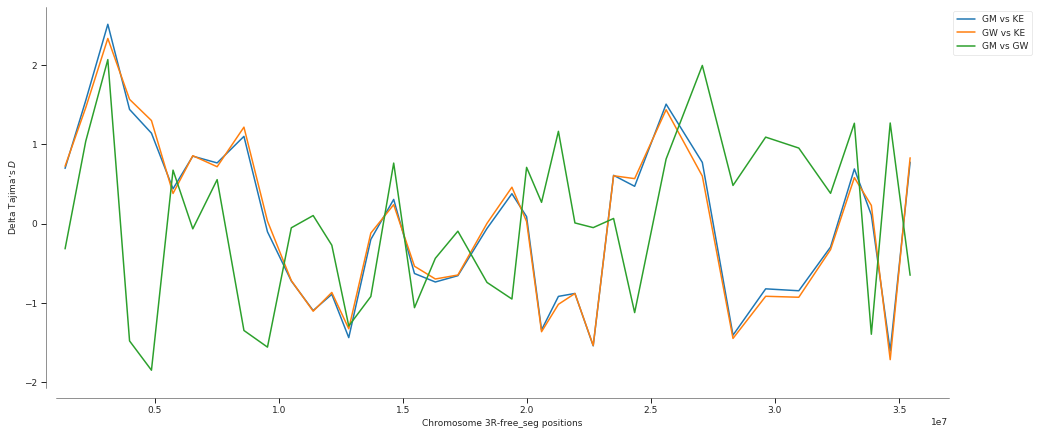

In [103]:
windows = allel.moving_statistic(pos_3R_free_seg, statistic=lambda v: [v[0], v[-1]], size=3000)
x = np.asarray(windows).mean(axis=1)
# plot
fig, ax = plt.subplots(figsize=(16, 7))
sns.despine(ax=ax, offset=10)
ax.plot(x, t1, lw=1.5, label='GM vs KE')
ax.plot(x, t2, lw=1.5, label='GW vs KE')
ax.plot(x, t3, lw=1.5, label='GM vs GW')

ax.set_ylabel("Delta Tajima’s $D$")
ax.set_xlabel('Chromosome 3R-free_seg positions')
ax.set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));

-------------------------
Average Dxy

In [217]:
av_dxy1, windows1, n_bases1, counts1 = allel.windowed_divergence(pos_3R_free_seg, ac_seg['GM'], ac_seg['KE'],size=3000, start=pos_3R_free_seg.min(), stop=pos_3R_free_seg.max(), is_accessible=is_accessible)
av_dxy2, windows2, n_bases2, counts2 = allel.windowed_divergence(pos_3R_free_seg, ac_seg['GW'], ac_seg['KE'],size=3000, start=pos_3R_free_seg.min(), stop=pos_3R_free_seg.max(), is_accessible=is_accessible)
av_dxy3, windows3, n_bases3, counts3 = allel.windowed_divergence(pos_3R_free_seg, ac_seg['GM'], ac_seg['GW'],size=3000, start=pos_3R_free_seg.min(), stop=pos_3R_free_seg.max(), is_accessible=is_accessible)

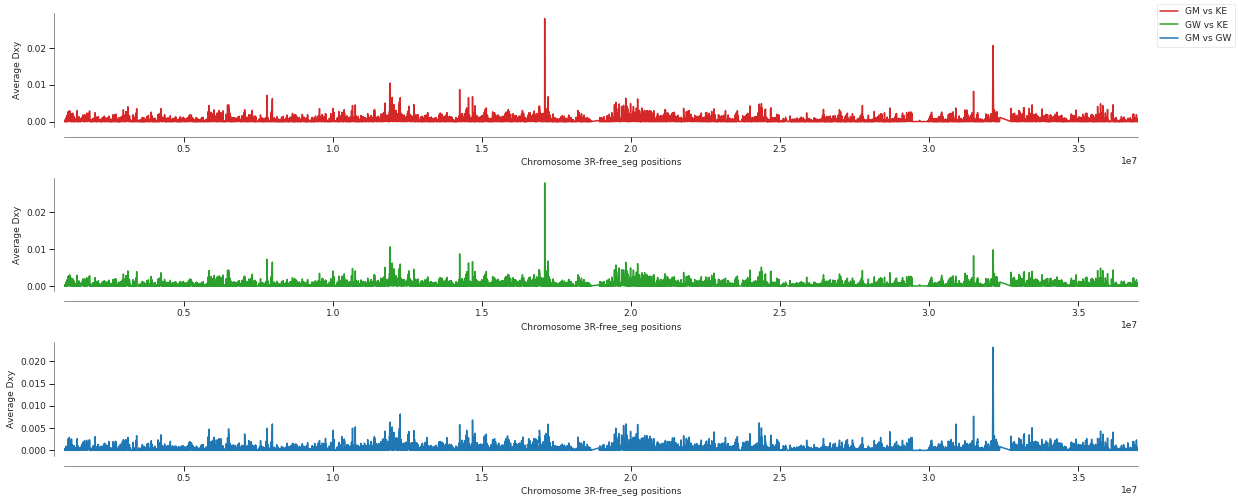

In [218]:
min_n_bases=1
# plot

fig, ax = plt.subplots(3, figsize=(16, 7))

x1 = np.mean(windows1[n_bases1 >= min_n_bases], axis=1)
y1 = av_dxy1[n_bases1 >= min_n_bases]

ax[0].plot(x1, y1, lw=1.5, label='GM vs KE', color=palette[3])
sns.despine(ax=ax[0], offset=10)
ax[0].set_ylabel("Average Dxy")
ax[0].set_xlabel('Chromosome 3R-free_seg positions')
ax[0].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())

x2 = np.mean(windows2[n_bases2 >= min_n_bases], axis=1)
y2 = av_dxy2[n_bases2 >= min_n_bases]

ax[1].plot(x2, y2, lw=1.5, label='GW vs KE', color=palette[2])
sns.despine(ax=ax[1], offset=10)
ax[1].set_ylabel("Average Dxy")
ax[1].set_xlabel('Chromosome 3R-free_seg positions')
ax[1].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())

x3 = np.mean(windows3[n_bases3 >= min_n_bases], axis=1)
y3 = av_dxy3[n_bases3 >= min_n_bases]
ax[2].plot(x, y3, lw=1.5, label='GM vs GW', color=palette[0])
sns.despine(ax=ax[2], offset=10)
ax[2].set_ylabel("Average Dxy")
ax[2].set_xlabel('Chromosome 3R-free_seg positions')
ax[2].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(1, 1));

-----------------------------
Watterson's theta

In [232]:
wat_gm, windows1, n_bases1, counts1 = allel.windowed_watterson_theta(pos_3R_free_seg, ac_seg['GM'],size=100000, start=pos_3R_free_seg.min(), stop=pos_3R_free_seg.max(), is_accessible=is_accessible)
wat_gw, windows2, n_bases2, counts2 = allel.windowed_watterson_theta(pos_3R_free_seg, ac_seg['GW'],size=100000, start=pos_3R_free_seg.min(), stop=pos_3R_free_seg.max(), is_accessible=is_accessible)
wat_ke, windows3, n_bases3, counts3 = allel.windowed_watterson_theta(pos_3R_free_seg, ac_seg['KE'],size=100000, start=pos_3R_free_seg.min(), stop=pos_3R_free_seg.max(), is_accessible=is_accessible)

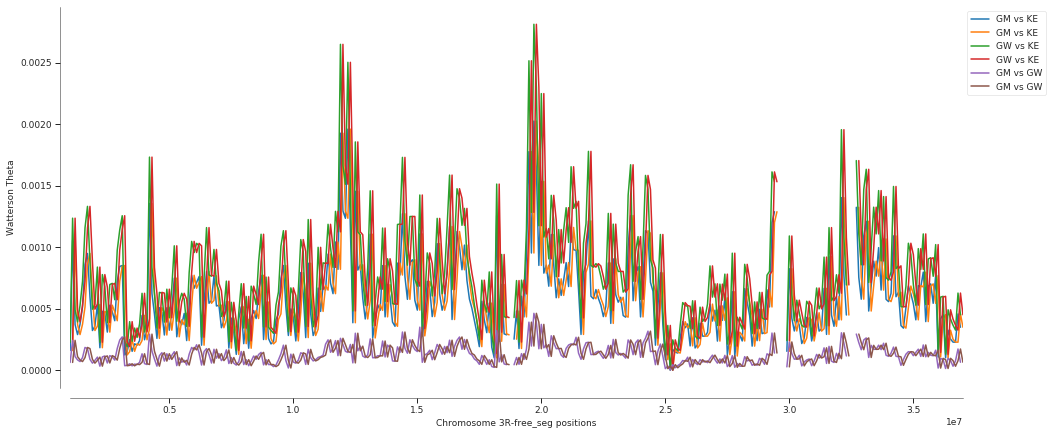

In [288]:
# plot
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(windows1, wat_gm, lw=1.5, label='GM vs KE')
ax.plot(windows2, wat_gw, lw=1.5, label='GW vs KE')
ax.plot(windows3, wat_ke, lw=1.5, label='GM vs GW')

ax.set_ylabel("Watterson Theta")
ax.set_xlabel('Chromosome 3R-free_seg positions')
ax.set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())
sns.despine(ax=ax, offset=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

---------------------------------------

Expected heterozigosity

In [272]:
af1 = allel.heterozygosity_expected(ac_seg['GM'].to_frequencies(),2)
af2 = allel.heterozygosity_expected(ac_seg['GW'].to_frequencies(),2)
af3 = allel.heterozygosity_expected(ac_seg['KE'].to_frequencies(),2)

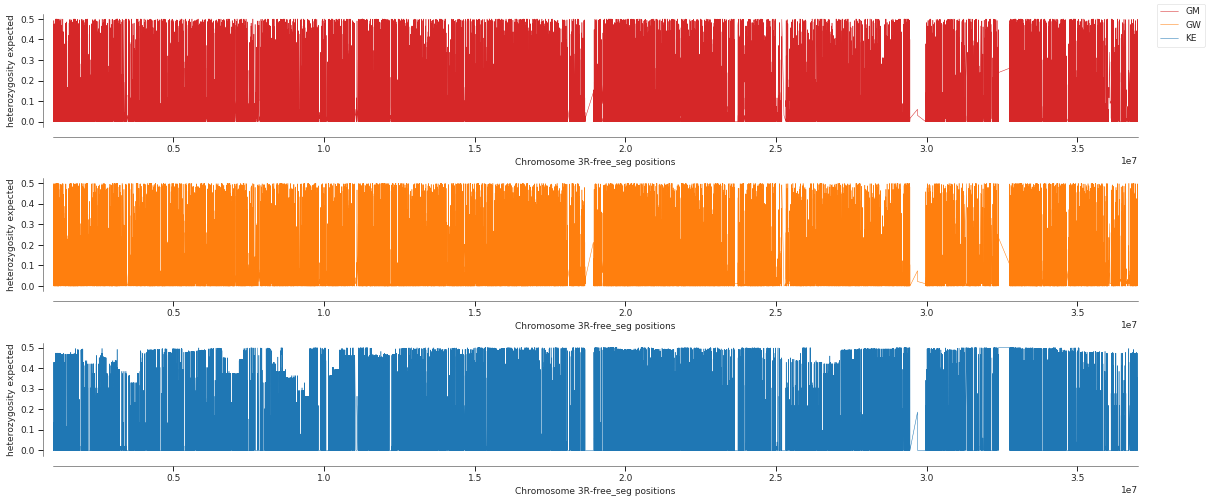

In [273]:
windows = allel.moving_statistic(pos_3R_free_seg, statistic=lambda v: [v[0], v[-1]], size=1)
x = np.asarray(windows).mean(axis=1)
# plot
fig, ax = plt.subplots(3, figsize=(16, 7))

ax[0].plot(x, af1, lw=.5, label='GM', color=palette[3])
sns.despine(ax=ax[0], offset=10)
ax[0].set_ylabel("heterozygosity expected")
ax[0].set_xlabel('Chromosome 3R-free_seg positions')
ax[0].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())


ax[1].plot(x, af2, lw=.5, label='GW', color=palette[1])
sns.despine(ax=ax[1], offset=10)
ax[1].set_ylabel("heterozygosity expected")
ax[1].set_xlabel('Chromosome 3R-free_seg positions')
ax[1].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())

ax[2].plot(x, af3, lw=.5, label='KE', color=palette[0])
sns.despine(ax=ax[2], offset=10)
ax[2].set_ylabel("heterozygosity expected")
ax[2].set_xlabel('Chromosome 3R-free_seg positions')
ax[2].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(1, 1));

---------------------------------

In [274]:
sample_selection_ke = samples_subset.population.isin({'KE'}).values
sample_selection_gw = samples_subset.population.isin({'GW'}).values
sample_selection_gm = samples_subset.population.isin({'GM'}).values

In [275]:
geno_seg_ke = genotypes_seg.subset(sel1= sample_selection_ke)
geno_seg_gw = genotypes_seg.subset(sel1= sample_selection_gw)
geno_seg_gm = genotypes_seg.subset(sel1= sample_selection_gm)

In [276]:
ho_ke = allel.heterozygosity_observed(geno_seg_ke)
ho_gw = allel.heterozygosity_observed(geno_seg_gw)
ho_gm = allel.heterozygosity_observed(geno_seg_gm)

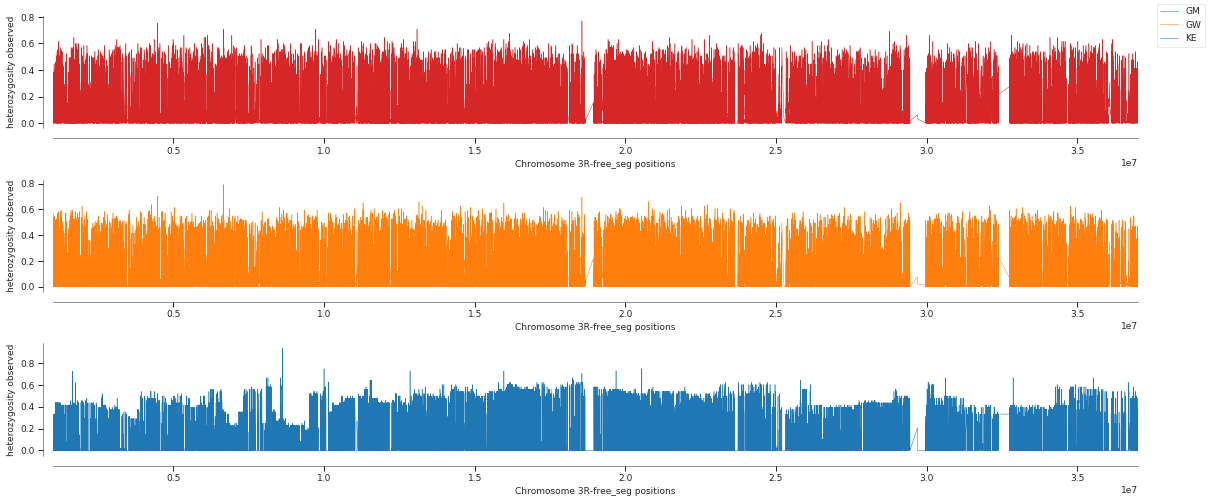

In [277]:
windows = allel.moving_statistic(pos_3R_free_seg, statistic=lambda v: [v[0], v[-1]], size=1)
x = np.asarray(windows).mean(axis=1)
# plot
fig, ax = plt.subplots(3, figsize=(16, 7))

ax[0].plot(x, ho_gm, lw=.5, label='GM', color=palette[3])
sns.despine(ax=ax[0], offset=10)
ax[0].set_ylabel("heterozygosity observed")
ax[0].set_xlabel('Chromosome 3R-free_seg positions')
ax[0].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())


ax[1].plot(x, ho_gw, lw=.5, label='GW', color=palette[1])
sns.despine(ax=ax[1], offset=10)
ax[1].set_ylabel("heterozygosity observed")
ax[1].set_xlabel('Chromosome 3R-free_seg positions')
ax[1].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())

ax[2].plot(x, ho_ke, lw=.5, label='KE', color=palette[0])
sns.despine(ax=ax[2], offset=10)
ax[2].set_ylabel("heterozygosity observed")
ax[2].set_xlabel('Chromosome 3R-free_seg positions')
ax[2].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(1, 1));

------------------------
Heterozigosity observed vs Heterozigosity expected

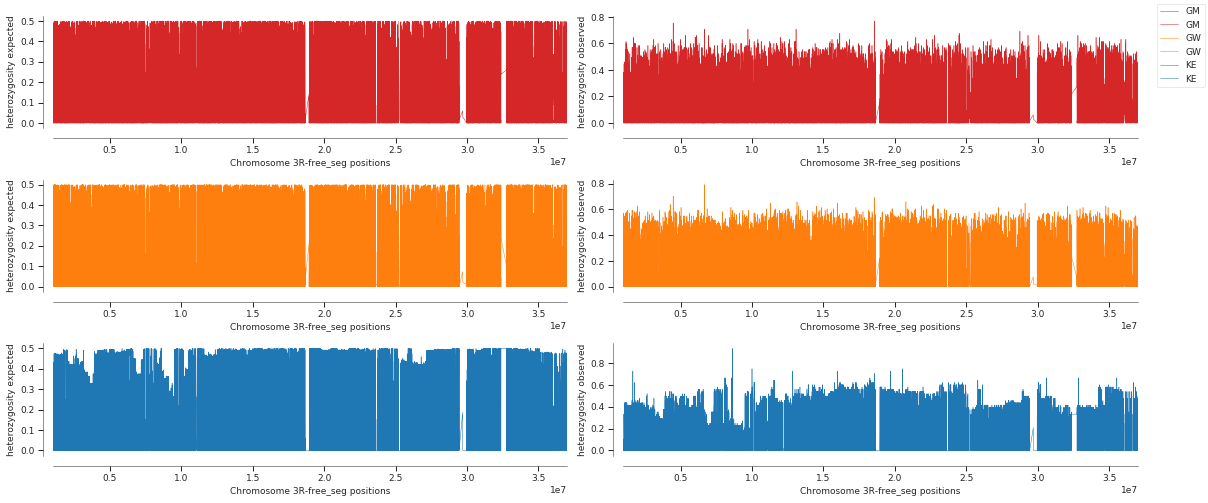

In [278]:
# plot
fig, ax = plt.subplots(3,2,figsize=(16,7))
ax[0,0].plot(x, af1, lw=.5, label='GM', color=palette[3])
sns.despine(ax=ax[0,0], offset=10)
ax[0,0].set_ylabel("heterozygosity expected")
ax[0,0].set_xlabel('Chromosome 3R-free_seg positions')
ax[0,0].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())


ax[1,0].plot(x, af2, lw=.5, label='GW', color=palette[1])
sns.despine(ax=ax[1,0], offset=10)
ax[1,0].set_ylabel("heterozygosity expected")
ax[1,0].set_xlabel('Chromosome 3R-free_seg positions')
ax[1,0].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())

ax[2,0].plot(x, af3, lw=.5, label='KE', color=palette[0])
sns.despine(ax=ax[2,0], offset=10)
ax[2,0].set_ylabel("heterozygosity expected")
ax[2,0].set_xlabel('Chromosome 3R-free_seg positions')
ax[2,0].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())

ax[0,1].plot(x, ho_gm, lw=.5, label='GM', color=palette[3])
sns.despine(ax=ax[0,1], offset=10)
ax[0,1].set_ylabel("heterozygosity observed")
ax[0,1].set_xlabel('Chromosome 3R-free_seg positions')
ax[0,1].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())


ax[1,1].plot(x, ho_gw, lw=.5, label='GW', color=palette[1])
sns.despine(ax=ax[1,1], offset=10)
ax[1,1].set_ylabel("heterozygosity observed")
ax[1,1].set_xlabel('Chromosome 3R-free_seg positions')
ax[1,1].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())

ax[2,1].plot(x, ho_ke, lw=.5, label='KE', color=palette[0])
sns.despine(ax=ax[2,1], offset=10)
ax[2,1].set_ylabel("heterozygosity observed")
ax[2,1].set_xlabel('Chromosome 3R-free_seg positions')
ax[2,1].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())
fig.legend(loc='upper left', bbox_to_anchor=(1, 1));
fig.tight_layout()

---------------------------

Inbreeding coefficent

In [178]:
ic_ke = allel.inbreeding_coefficient(geno_seg_ke)
ic_gw = allel.inbreeding_coefficient(geno_seg_gw)
ic_gm = allel.inbreeding_coefficient(geno_seg_gm)

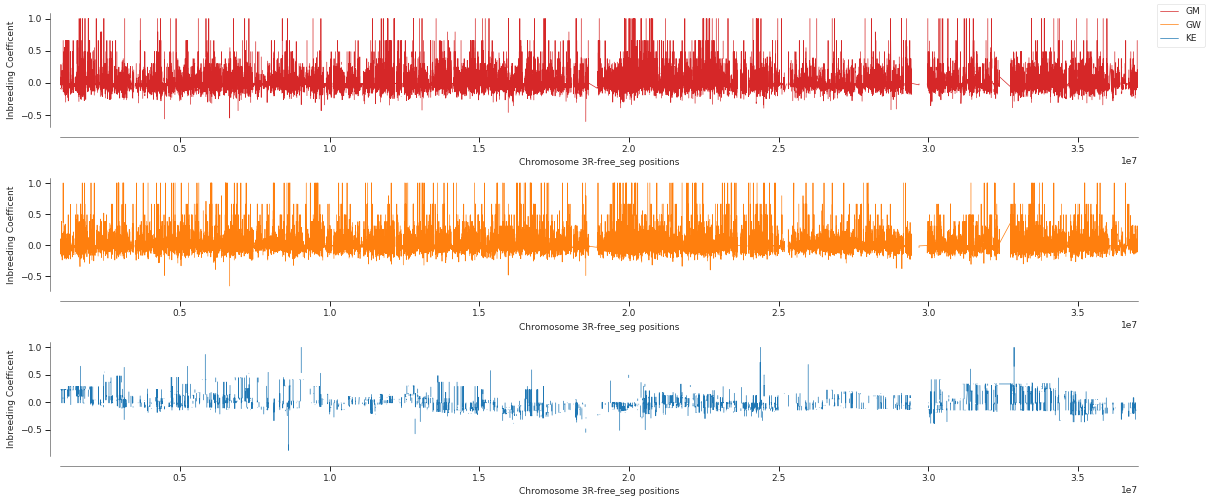

In [180]:
windows = allel.moving_statistic(pos_3R_free_seg, statistic=lambda v: [v[0], v[-1]], size=1)
x = np.asarray(windows).mean(axis=1)
# plot
fig, ax = plt.subplots(3, figsize=(16, 7))

ax[0].plot(x, ic_gm, lw=.7, label='GM', color=palette[3])
sns.despine(ax=ax[0], offset=10)
ax[0].set_ylabel("Inbreeding Coefficent")
ax[0].set_xlabel('Chromosome 3R-free_seg positions')
ax[0].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())


ax[1].plot(x, ic_gw, lw=.7, label='GW', color=palette[1])
sns.despine(ax=ax[1], offset=10)
ax[1].set_ylabel("Inbreeding Coefficent")
ax[1].set_xlabel('Chromosome 3R-free_seg positions')
ax[1].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())

ax[2].plot(x, ic_ke, lw=.7, label='KE', color=palette[0])
sns.despine(ax=ax[2], offset=10)
ax[2].set_ylabel("Inbreeding Coefficent")
ax[2].set_xlabel('Chromosome 3R-free_seg positions')
ax[2].set_xlim(pos_3R_free_seg.min(), pos_3R_free_seg.max())
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(1, 1));